# IPBMA_6: Projection Radiography
### Author: Liu Cong and Ulloa Ferrer,Leonardo

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import sys, os
from auxFiles.auxFnc import *
from auxFiles.phantomsFnc import *
from auxFiles.plotFnc import *

try:
    auxFnc = os.path.join(sys.path[0], 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join(sys.path[0], 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join(sys.path[0], 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}
except:
    auxFnc = os.path.join('.', 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join('.', 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join('.', 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}

SOURCE

In [2]:
# source(kVp, N0)
# return number of photoms (N0), efective energy (eE)

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)

print(N0, eE)

250 12.0


BREAST PHANTOM

In [3]:
# OBJECT
# phantom(size, eE)
# return phantomData

size= 256
obj= breast_phantom(size, eE)

0.0 2.27 3.19 4.14


QUANTUM IMAGE. FRONTAL VIEW.

In [4]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'frontal'
img= interactor_PR(N0, obj, prj)

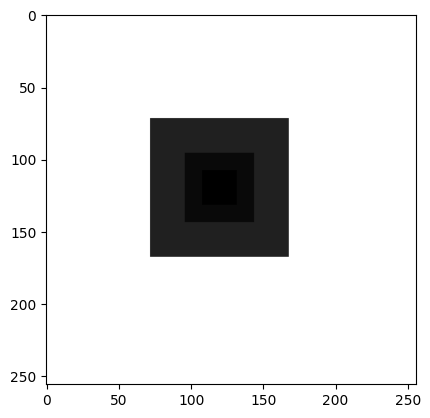

In [5]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

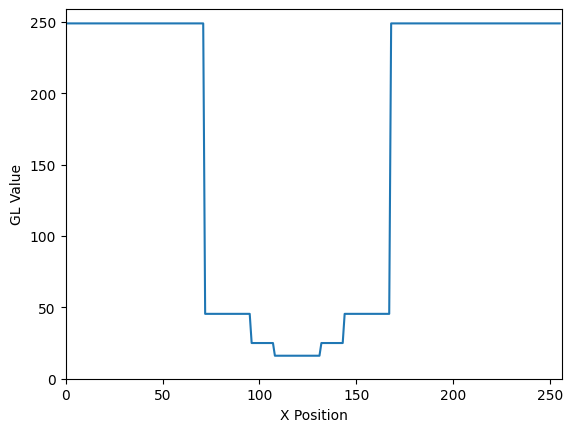

In [6]:
plotLineH(img, 128)

In [7]:
# Get Distribution of cells per Photons

nCP= getNumberCellsPhoton(img, N0)
print(f'Number of Cells (Quantum image): {int(sum(nCP[1])):d}')

Number of Cells (Quantum image): 65536


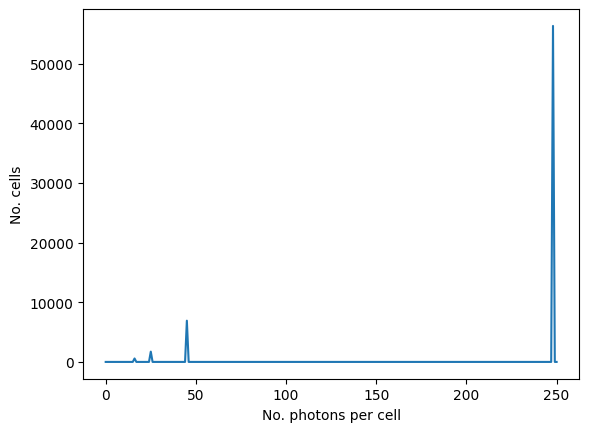

In [8]:
plotDistribution(nCP, 'No. photons per cell', 'No. cells')

QUANTUM IMAGE. LATERAL VIEW.

In [9]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'lateral'
img= interactor_PR(N0, obj, prj)

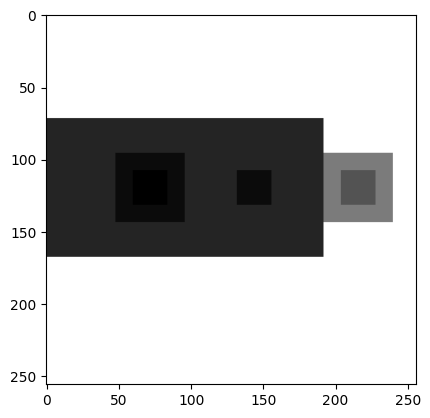

In [10]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

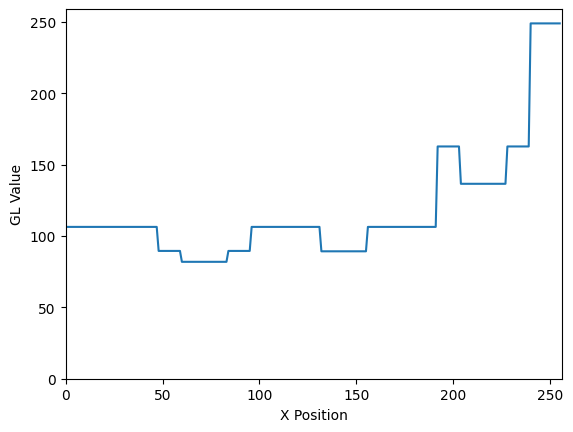

In [11]:
plotLineH(img, 128)

In [12]:
# fName= "coefAtenuacionAir.csv"
fName= "coefAtenuacionCalcium.csv"
mu= getCoef(fName, eE)
sArtifact= 2

In [13]:
pos_1= [72, 120, 120]
obj_microCal= insertArtifact(obj, pos_1, sArtifact, mu)

pos_2= [144, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_2, sArtifact, mu)

pos_3= [214, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_3, sArtifact, mu)

In [14]:
img= interactor_PR(N0, obj_microCal, prj)

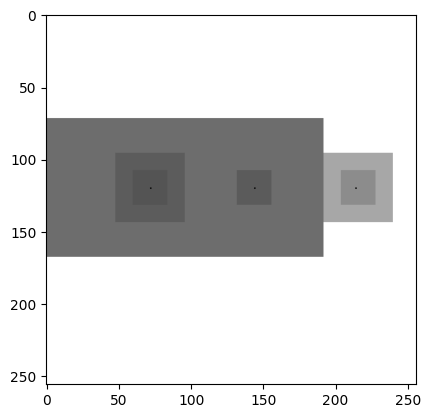

In [15]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

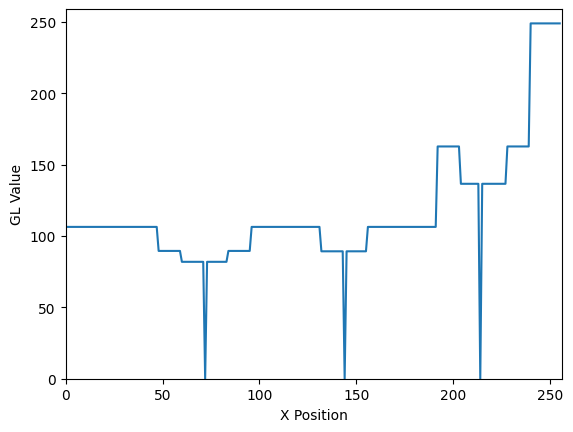

In [16]:
plotLineH(img, 120)

DETECTED IMAGE

In [17]:
# Detection
# dImage -> The detected image, without noise.

f= 2
QDE= 0.75
dImage= detector_QDE(img, int(size/f), int(size/f), QDE)

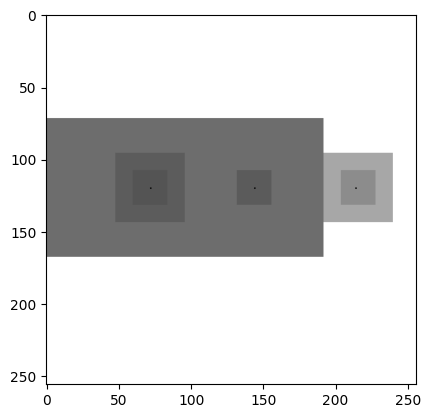

In [18]:
pyplot.imshow(img, cmap="gray")
pyplot.show()

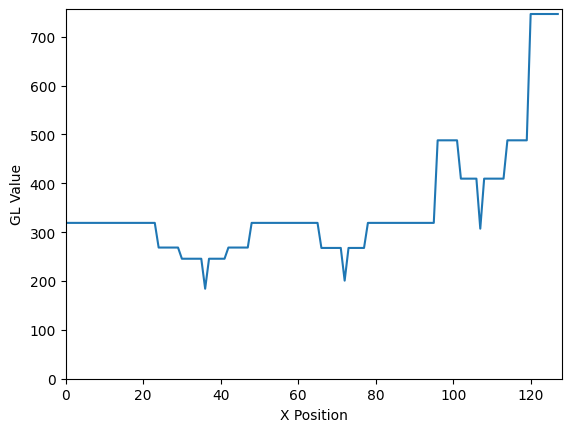

In [19]:
plotLineH(dImage, int(120/f))

In [20]:
nCP= getNumberCellsPhoton(dImage, N0*3)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 16384
Number of Photons (Detected image): 10062357
Number of Photons (Quantum image): 13416477
Percentage Detected: 75.00%


In [41]:
# Detection
# dImageNoise -> The detected image, under the hypothesis of Poisson distribution.
from PIL import Image

f= 2
QDE= 0.75
dImageNoise= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

In [42]:
nCP= getNumberCellsPhoton(dImageNoise, N0*3)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImageNoise, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 11456
Number of Photons (Detected image): 10065063
Number of Photons (Quantum image): 13416477
Percentage Detected: 75.02%


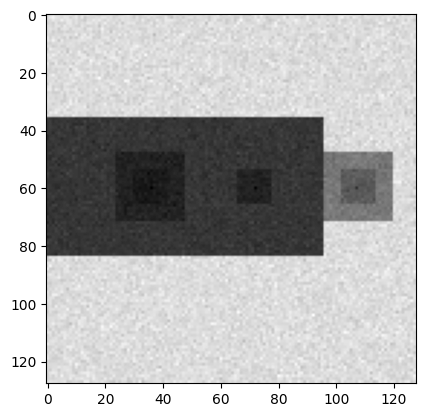

In [43]:
pyplot.imshow(dImageNoise, cmap="gray")
pyplot.show()

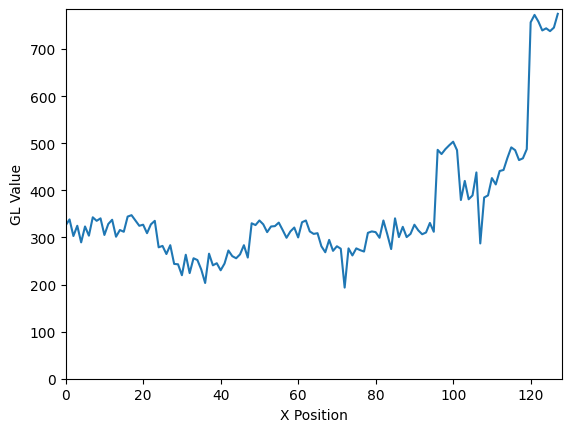

In [24]:
plotLineH(dImageNoise, int(120/f))

### Experiments
Experiment 1. Microcalcification visualization.

In [25]:
# SOURCE

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)
QDE= 0.75

print(N0, eE)

250 12.0


In [26]:
# OBJECT

size= 256
obj= breast_phantom(size, eE)

0.0 2.27 3.19 4.14


In [27]:
# MICROCALCIFICATION INSERTION
fName= "coefAtenuacionCalcium.csv"
mu= getCoef(fName, eE)
sArtifact= 2

pos_1= [72, 120, 120]
obj_microCal= insertArtifact(obj, pos_1, sArtifact, mu)

pos_2= [144, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_2, sArtifact, mu)

pos_3= [214, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_3, sArtifact, mu)

In [28]:
# INTERACTION

prj= 'lateral'
img= interactor_PR(N0, obj_microCal, prj)

Experiment 1.1. Baseline --> Quantum Image Resolution == Detected Image Resolution

In [29]:
f= 1
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

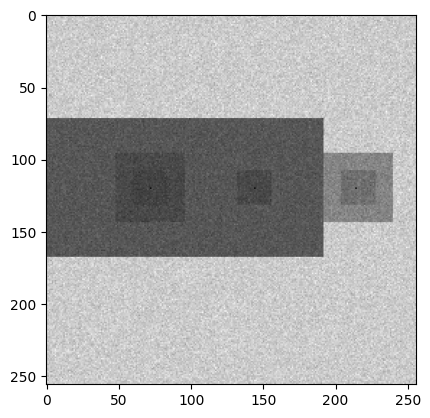

In [30]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

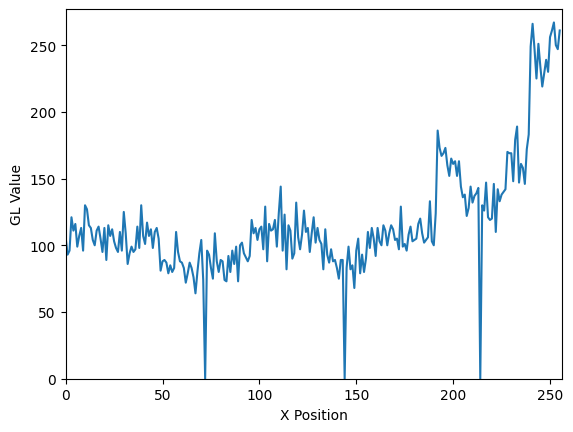

In [31]:
plotLineH(dImage, int(120/f))

Experiment 1.2. Quantum Image Resolution < Detected Image Resolution

In [32]:
f= 0.5
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

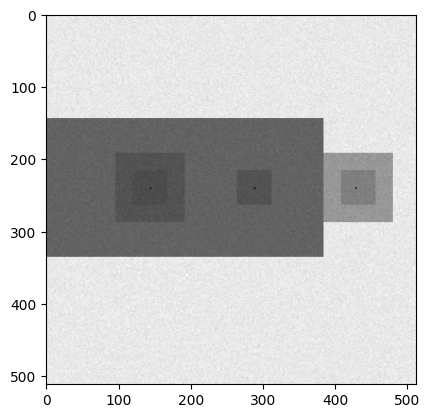

In [ ]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

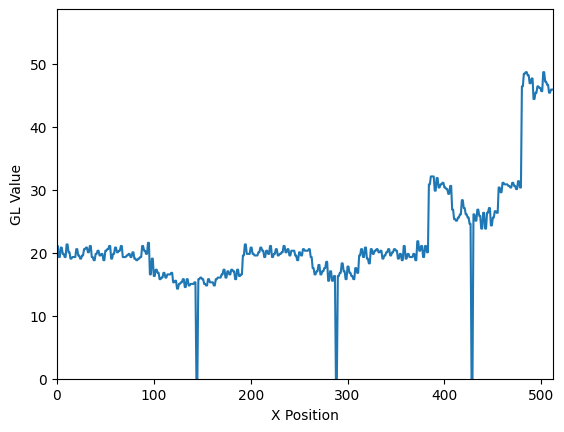

In [ ]:
plotLineH(dImage, int(120/f))

Experiment 1.3. Quantum Image Resolution > Detected Image Resolution

In [ ]:
f= 2
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

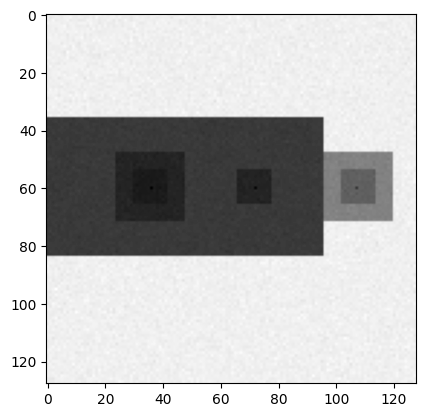

In [ ]:
pyplot.imshow(dImage, cmap="gray")
pyplot.show()

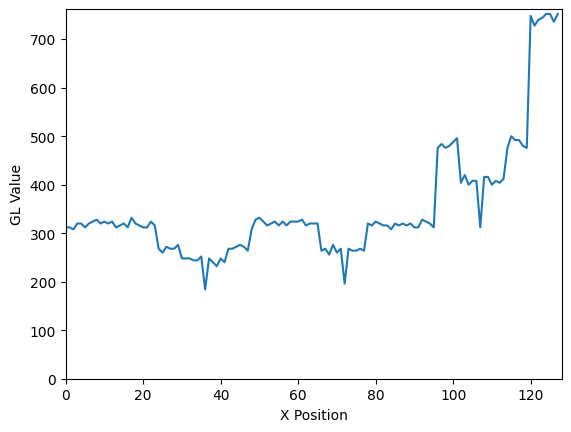

In [ ]:
plotLineH(dImage, int(120/f))

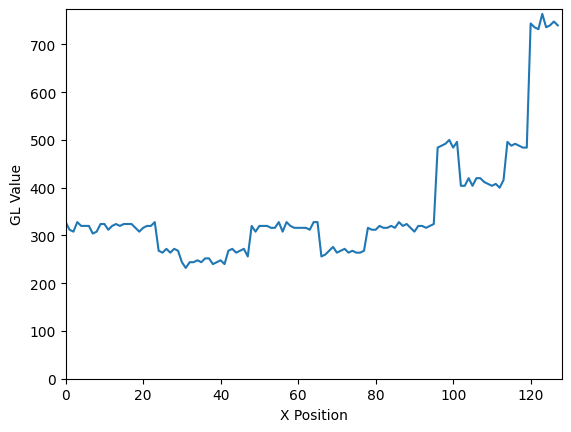

In [ ]:
plotLineH(dImage, int(120/f)-1)    # Better option to visualize the microcalcification

Experiment 2. Noise vs Spatial Resolution Analysis.

In [ ]:
# SOURCE

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)
QDE= 0.8

print(N0, eE)

250 12.0


In [ ]:
# OBJECT

size= 256
obj= cube_phantom_nh(size, eE)

4.14 0.0 3.87


In [ ]:
# INTERACTION

prj= 'frontal'
img= interactor_PR(N0, obj, prj)

Experiment 2.1. Baseline --> Quantum Image Resolution == Detected Image Resolution

In [ ]:
# DETECTION

f= 1
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

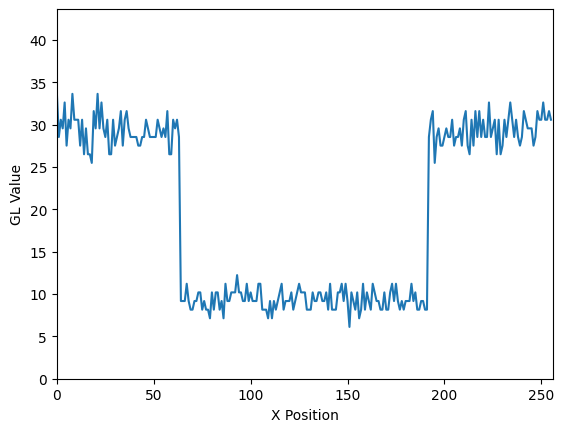

In [ ]:
plotLineH(dImage, int(120/f))

In [ ]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 65536


Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [ ]:
# SNR 1

w= 10
snr_1= getSNR(dImage, 128, 128, w)

print(f'SNR 1: {snr_1: .3f}')

SNR 1:  9.756


Experiment 2.2. Quantum Image Resolution < Detected Image Resolution

In [ ]:
# DETECTION

f= 0.5
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

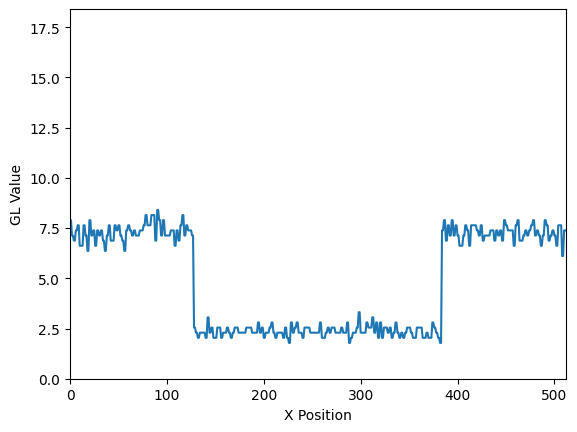

In [ ]:
plotLineH(dImage, int(120/f))

In [ ]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 262144
Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [ ]:
# SNR 2

w= 10
snr_2= getSNR(dImage, 256, 256, w)

print(f'SNR 1: {snr_2: .3f}')

SNR 1:  10.409


Experiment 2.3. Quantum Image Resolution > Detected Image Resolution

In [ ]:
# DETECTION

f= 4
dImage= detectorNoiseFullP_QDE(img, int(size/f), int(size/f), QDE)

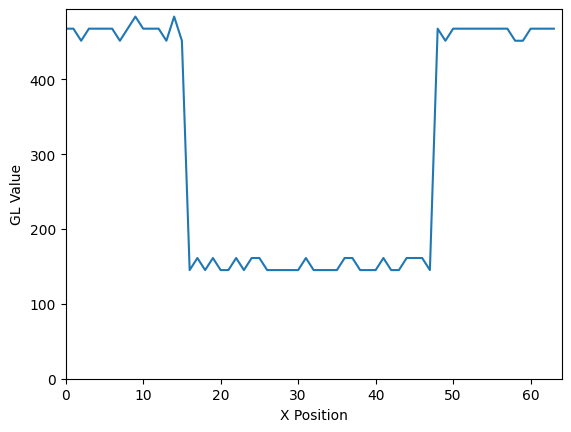

In [ ]:
plotLineH(dImage, int(120/f))

In [ ]:
nCP= getNumberCellsPhoton(dImage, N0)
print(f'Number of Cells (Detected image): {int(sum(nCP[1])):d}')
nPCD= getNumberPhotonsCell(dImage, N0)
print(f'Number of Photons (Detected image): {int(sum(nPCD[1])):d}')
nPCQ= getNumberPhotonsCell(img, N0)
print(f'Number of Photons (Quantum image): {int(sum(nPCQ[1])):d}')
print(f'Percentage Detected: {100*sum(nPCD[1])/sum(nPCQ[1]):.2f}%')

Number of Cells (Detected image): 1024
Number of Photons (Detected image): 1576886
Number of Photons (Quantum image): 1971107
Percentage Detected: 80.00%


In [ ]:
# SNR 3

w= 10
snr_3= getSNR(dImage, 32, 32, w)

print(f'SNR 3: {snr_3: .3f}')

SNR 3:  19.603


In [ ]:
print(f'SNR 1: {snr_1: .3f}')
print(f'SNR 2: {snr_2: .3f}')
print(f'SNR 3: {snr_3: .3f}')

SNR 1:  9.756
SNR 2:  10.409
SNR 3:  19.603


In [ ]:
assert snr_1 > snr_2 and snr_1 < snr_3, "Something wrong happens"

AssertionError: Something wrong happens